In [1]:
import torch
import torch.nn as nn
import time
from ode_nn import Seq2Seq, Auto_FC, Transformer, Latent_ODE, Transformer2
from ode_nn import Dataset, train_epoch, eval_epoch, get_lr
import numpy as np
import time
from torch.utils import data
import matplotlib.pyplot as plt
import random
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

Using backend: pytorch


In [2]:
input_length = 10
mid = 10
output_length = 10
batch_size = 1
####################################
direc = '/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/LV_2/sample_'
random.seed(1521)
indices = list(range(1000, 6000))
random.shuffle(indices)
train_indices = indices[:3500]
valid_indices = indices[3500:4000]
test_inter_indices = indices[4000:5000][::100]

#test_extra_up_indices = list(range(0, 500))
test_extra_down_indices = list(range(0, 1000))[::100]
####################################
train_set = Dataset(train_indices, input_length, mid, output_length, direc, entire_target = True)
valid_set = Dataset(valid_indices, input_length, mid, output_length, direc, entire_target = True)
test_inter_set = Dataset(test_inter_indices, input_length, mid, output_length, direc, entire_target = True)#, direc, N = 1000, entire_target = True
test_down_set = Dataset(test_extra_down_indices, input_length, mid, output_length, direc, entire_target = True) #, direc, N = 1000, entire_target = True
#test_up_set = Dataset(test_extra_up_indices, input_length, mid, output_length, direc)#, entire_target = True

train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
valid_loader = data.DataLoader(valid_set, batch_size = batch_size, shuffle = False)
test_inter_loader = data.DataLoader(test_inter_set, batch_size = batch_size, shuffle = False)
test_down_loader = data.DataLoader(test_down_set, batch_size = batch_size, shuffle = False)
#test_up_loader = data.DataLoader(test_up_set, batch_size = batch_size, shuffle = False)

## AutoODE

In [11]:
class Auto_ODE_LV(nn.Module):
    def __init__(self, num_time_series, p0):
        super(Auto_ODE_LV, self).__init__()
        self.num_time_series = num_time_series
        self.p0 = p0#nn.Parameter(torch.rand(num_time_series).float())
        self.r = nn.Parameter(torch.rand(num_time_series).float()/10)
        self.k = nn.Parameter(torch.rand(num_time_series).float()*100)
        self.A = nn.Parameter(torch.rand(num_time_series, num_time_series).float()/10)
        
    def solve(self, num_steps):
        p = [] 
        p.append(self.p0)
        for n in range(num_steps-1): # element-wise vector division and multiplication
            mat_vec_prod = torch.mm(self.A, p[n].reshape(-1, 1)).squeeze(-1)
            p.append((1 + self.r * (1 - mat_vec_prod )) * p[n])#/ self.k

        return torch.cat(p, dim=0).reshape(num_steps, self.num_time_series)#.T

    def forward(self, num_steps):
        return self.solve(num_steps)       

In [28]:
preds = []
trues = []
for xx, yy in test_down_loader:
    model_ode = Auto_ODE_LV(4, xx[0,0].cpu())#.cuda()
    y_exact = xx[0].cpu()

    optimizer = torch.optim.Adam(model_ode.parameters(), 0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 100, gamma=0.9)
    num_epochs = 3000
    loss_fun = torch.nn.MSELoss()
    #tqdm_epochs = tqdm()
    min_loss = 10

    for e in range(num_epochs):
        scheduler.step()
        y_approx = model_ode(10)
        loss = loss_fun(y_approx, y_exact)
        if loss.item() < min_loss:
            best_model_ode = model_ode
            min_loss = torch.sum(loss).item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()})
        
    y_pred = best_model_ode(20).cpu().data.numpy()
    y_exact = yy[0].cpu().data.numpy()
    preds.append(y_pred)
    trues.append(y_exact)
    print(e)
y_preds = np.array(preds)
y_trues = np.array(trues)
print(np.sum(y_preds!=y_preds))
np.sqrt(np.mean((np.diff(y_preds, axis = 1) - np.diff(y_trues, axis = 1))[3:,-10:]**2))

torch.save({"preds": y_preds,
            "trues": y_trues,
            "rmse": np.sqrt(np.mean((np.diff(y_preds, axis = 1) - np.diff(y_trues, axis = 1))[:,-10:]**2))},
            "AutoODE_LV_init_inter.pt")

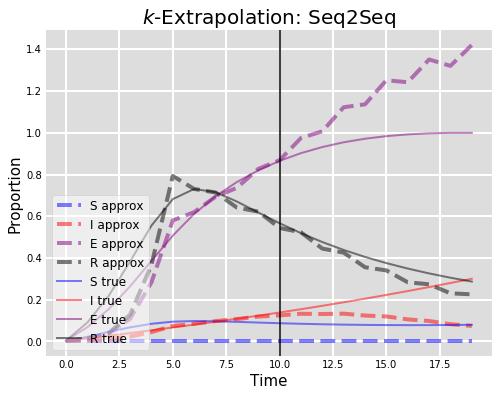

In [32]:
x = np.linspace(0, 60, 61)[:20]
fig=plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True) #80 6 130
idx = 7
y_pred = y_preds[idx]
y_true = y_trues[idx]
ax.plot(x, y_pred[:, 0], 'b', alpha=0.5, lw=4, linestyle = "--", label='S approx')
ax.plot(x, y_pred[:, 1], 'red', alpha=0.5, lw=4, linestyle = "--", label='I approx')
ax.plot(x, y_pred[:, 2], 'purple', alpha=0.5, lw=4, linestyle = "--", label= 'E approx')
ax.plot(x, y_pred[:, 3], 'black', alpha=0.5, lw=4, linestyle = "--", label= 'R approx')

ax.plot(x, y_true[:, 0], 'b', alpha=0.5, lw=2,  label='S true')
ax.plot(x, y_true[:, 1], 'red', alpha=0.5, lw=2,  label='I true')
ax.plot(x, y_true[:, 2], 'purple', alpha=0.5, lw=2,  label='E true')
ax.plot(x, y_true[:, 3], 'black', alpha=0.5, lw=2,  label='R true')


ax.axvline(10, color = "black")
ax.set_xlabel('Time', size = 15)
ax.set_ylabel('Proportion', size = 15)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize = 12, loc = 3)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    plt.title(r"$k$"+"-Extrapolation: Seq2Seq" , fontsize = 20)#+ r"$N=10000, I_0 = 10, \beta = 0.8, \gamma = 0.1$"
#plt.savefig("k-Extrapolation-lv.png", dpi = 400 , bbox_inches = "tight")    
plt.show()

In [6]:
preds = []
trues = []
for xx, yy in test_down_loader:
    time = torch.tensor(np.linspace(0, 60, 61), requires_grad=True).float()[:60]#.cuda()
    model_ode = Auto_ODE_SEIR(solver = "Euler")#.cuda()
    y_exact = xx[0]

    optimizer = torch.optim.Adam(model_ode.parameters(), 0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 100, gamma=0.95)
    num_epochs = 5000
    loss_fun = torch.nn.MSELoss()
    tqdm_epochs = tqdm(range(num_epochs))
    min_loss = 10

    for e in tqdm_epochs:
        scheduler.step()
        y_approx = model_ode(time[:30])
        loss = loss_fun(y_approx, y_exact[:30])
        #loss_weight = weight_fun(20, function = "linear", feat_weight = True)
        #loss = torch.mean(loss_weight*loss_fun(y_approx, y_exact[:30])) 

        if loss.item() < min_loss:
            best_model_ode = model_ode
            min_loss = torch.sum(loss).item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()})
        
    y_pred = best_model_ode(time).cpu().data.numpy()
    y_exact = yy[0].cpu().data.numpy()
    preds.append(y_pred)
    trues.append(y_exact)
    if len(preds) == 10:
        break

100%|██████████| 5000/5000 [01:20<00:00, 61.93it/s, loss=9.29e-5] 


In [10]:
y_preds = np.array(preds)
y_trues = np.array(trues)
print(np.sum(y_preds!=y_preds))
np.sqrt(np.mean((np.diff(y_preds, axis = 1) - np.diff(y_trues, axis = 1))[:,-40:]**2))*1000

y_preds = np.array(preds)
y_trues = np.array(trues)
torch.save({"preds": y_preds,
            "trues": y_trues,
            "rmse": np.sqrt(np.mean((np.diff(y_preds, axis = 1) - np.diff(y_trues, axis = 1))[:,-40:]**2))*1000},
            "AutoODE_SEIR_init_extra.pt")

In [ ]:
x = np.linspace(0, 60, 61)[:59]
fig=plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True) #80 6 130
idx = 0
y_pred = y_preds[idx]
y_true = y_trues[idx]
ax.plot(x, np.diff(y_pred[:, 0]), 'b', alpha=0.5, lw=4, linestyle = "--", label='S approx')
ax.plot(x, np.diff(y_pred[:, 1]), 'red', alpha=0.5, lw=4, linestyle = "--", label='I approx')
ax.plot(x, np.diff(y_pred[:, 2]), 'purple', alpha=0.5, lw=4, linestyle = "--", label= 'E approx')
ax.plot(x, np.diff(y_pred[:, 3]), 'black', alpha=0.5, lw=4, linestyle = "--", label= 'R approx')

ax.plot(x, np.diff(y_true[:, 0]), 'b', alpha=0.5, lw=2,  label='S true')
ax.plot(x, np.diff(y_true[:, 1]), 'red', alpha=0.5, lw=2,  label='I true')
ax.plot(x, np.diff(y_true[:, 2]), 'purple', alpha=0.5, lw=2,  label='E true')
ax.plot(x, np.diff(y_true[:, 3]), 'black', alpha=0.5, lw=2,  label='R true')


ax.axvline(30, color = "black")
ax.set_xlabel('Time', size = 15)
ax.set_ylabel('Proportion', size = 15)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize = 12, loc = 3)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    plt.title(r"$k$"+"-Extrapolation: Seq2Seq" , fontsize = 20)#+ r"$N=10000, I_0 = 10, \beta = 0.8, \gamma = 0.1$"
#plt.savefig("k-Extrapolation-lv.png", dpi = 400 , bbox_inches = "tight")    
plt.show()

## Train Model

In [ ]:
#model = nn.DataParallel(Auto_FC(input_length = input_length, input_dim = 4, output_dim = 4, hidden_dim = 1024).to(device))
#model = Seq2Seq(input_dim = 4, output_dim = 4, hidden_dim = 256, num_layers = 3).to(device)
#model = nn.DataParallel(Transformer(input_dim = 4, output_dim = 4, nhead = 4, d_model = 256, num_layers = 6, dim_feedforward = 512).to(device))#nn.DataParallel(
model = nn.DataParallel(Latent_ODE(latent_dim = 32, obs_dim = 4, nhidden = 256, nbatch=batch_size).to(device))
####################################
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.95)
loss_fun = nn.MSELoss()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
train_rmse = []
valid_rmse = []
test_rmse = []
min_rmse = 1

for i in range(1, 200):
    start = time.time()
    scheduler.step()
    model.train()
    train_rmse.append(train_epoch(model, train_loader, optimizer, loss_fun)[-1])
    model.eval()
    preds, trues, rmse = eval_epoch(model, valid_loader, loss_fun, concat_input = False)
    valid_rmse.append(rmse)
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model 
        torch.save(best_model, "latentode.pth")
    end = time.time()
    if (len(train_rmse) > 50 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break
    #if i%10 == 0:
    print("Epoch " + str(i) + ": ", "train rmse:", train_rmse[-1], "valid rmse:",valid_rmse[-1], 
                  "time:",round((end-start)/60,3), "Learning rate:", format(get_lr(optimizer), "5.2e"))

496196
Epoch 1:  train rmse: 0.37529 valid rmse: 0.31881 time: 10.35 Learning rate: 9.50e-04
Epoch 2:  train rmse: 0.3156 valid rmse: 0.31497 time: 6.566 Learning rate: 9.02e-04
Epoch 3:  train rmse: 0.31171 valid rmse: 0.31083 time: 12.582 Learning rate: 8.57e-04
Epoch 4:  train rmse: 0.30616 valid rmse: 0.30405 time: 25.02 Learning rate: 8.15e-04
Epoch 5:  train rmse: 0.29379 valid rmse: 0.28815 time: 45.193 Learning rate: 7.74e-04
Epoch 6:  train rmse: 0.27175 valid rmse: 0.26352 time: 63.883 Learning rate: 7.35e-04
Epoch 7:  train rmse: 0.25507 valid rmse: 0.23973 time: 78.753 Learning rate: 6.98e-04
Epoch 8:  train rmse: 0.23233 valid rmse: 0.21833 time: 89.547 Learning rate: 6.63e-04


In [12]:
preds_inter, trues_inter, rmse_inter = eval_epoch(best_model, test_inter_loader, loss_fun, concat_input = True)#
preds_down, trues_down, rmse_down = eval_epoch(best_model, test_down_loader, loss_fun, concat_input = True)#, concat_input = True
#preds_up, trues_up, rmse_up = eval_epoch(best_model, test_up_loader, loss_fun, concat_input = True)

torch.save({"Inter": [preds_inter, trues_inter, rmse_inter],
            "Down": [preds_down, trues_down, rmse_down],
            #"Up": [preds_up, trues_up, rmse_up],
            "model": best_model},
            "latentode_lv.pt")
# results = torch.load("Results/seq2seq.pt")
# preds_inter, trues_inter, rmse_inter = results["Inter"]
# preds_down, trues_down, rmse_down = results["Down"]

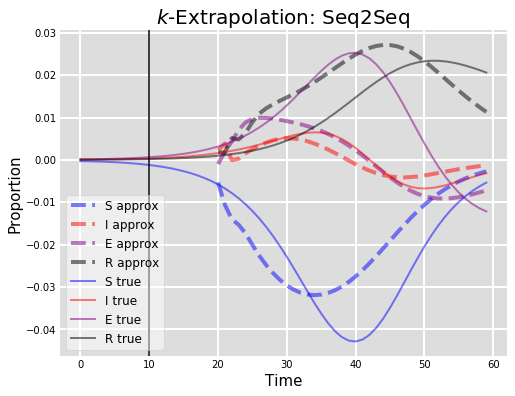

In [60]:
x = np.linspace(0, 60, 61)[:60]
fig=plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True) #80 6 130
idx = 0
num = 1
preds = [preds_inter, preds_down]# preds_up,
trues = [trues_inter, trues_down]#trues_up, 
ax.plot(x[20:], preds[num][idx, :, 0], 'b', alpha=0.5, lw=4, linestyle = "--", label='S approx')
ax.plot(x[20:], preds[num][idx, :, 1], 'red', alpha=0.5, lw=4, linestyle = "--", label='I approx')
ax.plot(x[20:], preds[num][idx, :, 2], 'purple', alpha=0.5, lw=4, linestyle = "--", label= 'E approx')
ax.plot(x[20:], preds[num][idx, :, 3], 'black', alpha=0.5, lw=4, linestyle = "--", label= 'R approx')

ax.plot(x, trues[num][idx, :, 0], 'b', alpha=0.5, lw=2,  label='S true')
ax.plot(x, trues[num][idx, :, 1], 'red', alpha=0.5, lw=2,  label='I true')
ax.plot(x, trues[num][idx, :, 2], 'purple', alpha=0.5, lw=2,  label='E true')
ax.plot(x, trues[num][idx, :, 3], 'black', alpha=0.5, lw=2,  label='R true')


ax.axvline(10, color = "black")
ax.set_xlabel('Time', size = 15)
ax.set_ylabel('Proportion', size = 15)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize = 12, loc = 3)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    plt.title(r"$k$"+"-Extrapolation: Seq2Seq" , fontsize = 20)#+ r"$N=10000, I_0 = 10, \beta = 0.8, \gamma = 0.1$"
#plt.savefig("k-Extrapolation-lv.png", dpi = 400 , bbox_inches = "tight")    
plt.show()

## Graph

In [ ]:
import torch
import torch.nn as nn
import time
import dgl
import numpy as np
import time
from torch.utils import data
import matplotlib.pyplot as plt
import random
from ode_nn import GCN, GAT, Dataset_graph, train_epoch_graph, eval_epoch_graph, get_lr
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [ ]:
input_length = 14
mid = 14
output_length = 7
batch_size = 2

###################################
train_direc = '/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/Latest_US_Covid_Data_0726/graph/train/sample_'
test_direc = '/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/Latest_US_Covid_Data_0726/graph/test/sample_'
train_indices = list(range(50))
valid_indices = list(range(50, 56))
test_indices = list(range(3))

###################################
train_set = Dataset_graph(train_indices, input_length, mid, output_length, train_direc)#, entire_target = True
valid_set = Dataset_graph(valid_indices, input_length, mid, output_length, train_direc)#, entire_target = True
test_set = Dataset_graph(test_indices, input_length, mid, output_length, test_direc)#, entire_target = True
train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
valid_loader = data.DataLoader(valid_set, batch_size = batch_size, shuffle = False)
test_loader = data.DataLoader(test_set, batch_size = batch_size, shuffle = False)

In [ ]:
graph = torch.load("us_graph.pt")
G = dgl.DGLGraph().to(device)
G.add_nodes(56)
for i in range(56):
    for j in range(56):
        if graph[i,j] == 1:
            G.add_edge(i,j)

In [ ]:
#model = GCN(in_dim = 42, out_dim = 3, hidden_dim = 64, num_layer = 5).to(device)
model = GAT(in_dim = 42, out_dim = 3, hidden_dim = 32, num_heads = 4, num_layer = 6).to(device)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.9)
loss_fun = nn.MSELoss()
sum(p.numel() for p in model.parameters() if p.requires_grad) 
train_rmse = []
valid_rmse = []
test_rmse = []
min_rmse = 1
for i in range(1, 100):
    start = time.time()
    scheduler.step()
    model.train()
    train_rmse.append(train_epoch_graph(model, train_loader, optimizer, loss_fun, G)[-1])
    model.eval()
    preds, trues, rmse = eval_epoch_graph(model, valid_loader, loss_fun, G)
    valid_rmse.append(rmse)
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model 
        #torch.save(best_model, "lstm_us.pth")
    end = time.time()
    if (len(train_rmse) > 30 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break
    print("Epoch " + str(i) + ": ", "train rmse:", train_rmse[-1], "valid rmse:",valid_rmse[-1], 
              "time:",round((end-start)/60,3), "Learning rate:", format(get_lr(optimizer), "5.2e"))
idx = 3
preds, trues, rmse = eval_epoch_graph(best_model, test_loader, loss_fun, G)
torch.save({"preds": preds,
            "trues": trues,
            "rmse": np.sqrt(np.mean((preds - trues[:,:,-7:])**2))}, 
            "GAT_" + str(idx) + ".pt")

In [ ]:
# dd = []
# for xx, yy in train_loader:
#     dd.append(xx.flatten())
#     dd.append(yy.flatten())
# dd_train = torch.cat(dd, dim = 0)

# dd = []
# for xx, yy in test_inter_loader:
#     dd.append(xx.flatten())
#     dd.append(yy.flatten())
# dd_inter = torch.cat(dd, dim = 0)

# dd = []
# for xx, yy in test_down_loader:
#     dd.append(xx.flatten())
#     dd.append(yy.flatten())
# dd_extra = torch.cat(dd, dim = 0)


# sns.set(color_codes=True)
# fig=plt.figure(figsize=(8, 6))
# sns.distplot(dd_train.flatten().cpu().data.numpy(), hist=False, bins = 20, 
#              kde_kws={"lw": 3, "label": "Training Set"})
# sns.distplot(dd_inter.flatten().cpu().data.numpy(), hist=False, bins = 20, 
#              kde_kws={"lw": 3, "label": r"$I_0$" + "-Interpolation Test Set"})
# sns.distplot(dd_extra.flatten().cpu().data.numpy(), hist=False, bins = 20, 
#              kde_kws={"lw": 3, "label": r"$I_0$" + "-Extrapolation Test Set"})

# plt.legend(fontsize='large')
# plt.title("SEIR Data Distribution", size = 16)
# plt.xlim(-60,40)
# #plt.savefig("SEIR-I-distribution.png", dpi = 300, bbox_inches = 'tight')